In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from pygam import LinearGAM, s, f 
import statsmodels.api as sm
import pylab as py
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import keras_tuner
print(tf.__version__)
print(keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.10.1
2.10.0
Num GPUs Available:  1


In [315]:
# open MHpredict csv file
MHpredict = pd.read_csv('MHpredict - Copy.csv')

# transform all categoricalvalues using LabelEncoder
## create a LabelEncoder object
le = LabelEncoder()

## iterate over the columns of the dataframe
## create empy list to store dtype of columns
type_cols = []
for col in MHpredict.columns:
  ## append the dtype of the column to the list
  type_cols.append(MHpredict[col].dtype)
  ## check if the column is of dtype object
  if MHpredict[col].dtype == 'object':
    ## fit and transform the column using the LabelEncoder
    MHpredict[col] = le.fit_transform(MHpredict[col])

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the DataFrame
scaled_df = scaler.fit_transform(MHpredict)

# Update the DataFrame with the scaled values
MHpredict_scaled = pd.DataFrame(scaled_df, columns=MHpredict.columns)

#  randomly split the dataset into a training (𝑛 = 1000) and test (𝑛 = 152)
train = MHpredict.sample(n=1000, random_state=3337731)
test = MHpredict.drop(train.index)

# splitting the training set into a training (80%) and validation set (20%)
#train, val = train_test_split(train, test_size=0.2, random_state=3337731)





In [316]:
MHpredict.describe()

,disType,Sexe,Age,aedu,IDS,BAI,FQ,LCImax,pedigree,alcohol,bTypeDep,bSocPhob,bGAD,bPanic,bAgo,AO,sample,dep_sev_fu
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,0.811632,0.336806,42.112847,11.760417,11.622396,10.453993,8.156250,0.503100,0.844618,0.691840,2.013021,0.378472,0.260417,0.348958,0.104167,20.979167,1.385417,16.908854
std,0.769829,0.472823,12.300584,3.269515,4.962128,7.013798,7.547468,0.339641,0.362426,0.461933,0.843437,0.485217,0.439053,0.476848,0.305609,12.610295,0.640967,5.306376
min,0.000000,0.000000,18.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.000000,0.000000,32.000000,10.000000,8.000000,5.000000,2.000000,0.207547,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,13.000000
50%,1.000000,0.000000,43.000000,11.000000,12.000000,9.000000,6.000000,0.425926,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.000000,17.000000
75%,1.000000,1.000000,52.000000,15.000000,15.000000,15.000000,12.000000,0.872727,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,28.000000,2.000000,20.000000
max,2.000000,1.000000,65.000000,18.000000,25.000000,42.000000,40.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,63.000000,2.000000,34.000000


In [317]:
#sns.pairplot(MHpredict)

In [318]:

y_train = train['dep_sev_fu']
X_train = train.drop('dep_sev_fu', axis=1)

y_test = test['dep_sev_fu']
X_test = test.drop('dep_sev_fu', axis=1)

#y_val = val['dep_sev_fu']
#X_val = val.drop('dep_sev_fu', axis=1)



In [319]:
### Generative Addative Model
# plot distribution of ordered dep_sev_fu values in MHpredict
# py.hist(MHpredict['dep_sev_fu'], bins=10, density=True, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')
#as well as qq plot:
#sm.qqplot(MHpredict['dep_sev_fu'], line ='45')
splines = 10

gam = LinearGAM(f(0)+f(1)+f(8)+f(9)+f(10)+f(11)+f(12)+f(13)+f(14)+f(16)+f(17)+f(18)+f(19)+
s(2,n_splines=splines)+s(3,n_splines=splines)+s(4,n_splines=splines)+s(5,n_splines=splines)+
s(6,n_splines=splines)+s(7,n_splines=splines)+s(16,n_splines=splines)+s(15,n_splines=splines)).fit(X_train, y_train)
gam.gridsearch(X_train, y_train, progress=True,return_scores=True)
gam.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     31.6452
Link Function:                     IdentityLink Log Likelihood:                                 -3670.2891
Number of Samples:                         1000 AIC:                                             7405.8686
                                                AICc:                                            7408.1418
                                                GCV:                                               16.0854
                                                Scale:                                             15.1718
                                                Pseudo R-Squared:                                   0.4854
Feature Function                  Lam

C:\Users\felix.wente\AppData\Local\Temp\ipykernel_19272\2506149277.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [320]:
# performance of the model
y_pred = gam.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the evaluation metrics
print("root mean squared error:", rmse)
print("mean absolute error:", mae)
print("R^2 score:", r2)

root mean squared error: 3.7222289795901706
mean absolute error: 3.0008738064013545
R^2 score: 0.4539682449654129


In [321]:
# devide rmse by range of dep_sev_fu
print("root mean squared error divided by range of dep_sev_fu:", rmse/(max(y_test)-min(y_test)))

root mean squared error divided by range of dep_sev_fu: 0.16919222634500775


In [322]:
### boosting with XGBoost

#cross validation with XGBoost

# Set up the parameters to search over



hp_space = {'max_depth': [3, 4, 5, 6, 7, 8, 9], 
                'gamma': [0, 0.5, 1, 1.5, 2, 5], 
                'subsample': [0.6, 0.7, 0.8, 0.9, 1], 
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                'learning_rate': [0.01, 0.1, 0.2, 0.3],
                'max_bin' : [256, 512, 1024]
               }

xgb = XGBRegressor(seed = 3337731, tree_method = "hist")
boost = RandomizedSearchCV(estimator = xgb, 
                   param_distributions = hp_space,
                   n_iter = 10, 
                   scoring = 'neg_root_mean_squared_error',
                   cv = 10,
                   verbose=0)
boost.fit(X_train, y_train,
        
    )

print("Best parameters:", boost.best_params_)
print("Lowest RMSE: ", -boost.best_score_)


c:\Users\felix.wente\anaconda3\envs\tf2_gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\felix.wente\anaconda3\envs\tf2_gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\felix.wente\anaconda3\envs\tf2_gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\felix.wente\anaconda3\envs\tf2_gpu\lib\site-packages\xgboost\data.py:250: FutureWarning:

Best parameters: {'subsample': 0.7, 'max_depth': 6, 'max_bin': 1024, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.5}
Lowest RMSE:  4.132519617253747


c:\Users\felix.wente\anaconda3\envs\tf2_gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\felix.wente\anaconda3\envs\tf2_gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\felix.wente\anaconda3\envs\tf2_gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [323]:
# split the X_train and y_train into a training (80%) and validation set (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3337731)

xg_boost = XGBRegressor(
    subsample= 1, 
    max_depth=8,
    max_bin=256, 
    learning_rate= 0.1, 
    gamma= 2,
    colsample_bytree= 0.6,  
    seed=3337731)



xg_boost.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:15.62460	validation_1-rmse:15.85440
[1]	validation_0-rmse:14.18425	validation_1-rmse:14.40763
[2]	validation_0-rmse:12.89546	validation_1-rmse:13.12508
[3]	validation_0-rmse:11.75207	validation_1-rmse:12.00337
[4]	validation_0-rmse:10.73874	validation_1-rmse:10.99093
[5]	validation_0-rmse:9.81832	validation_1-rmse:10.08886
[6]	validation_0-rmse:8.98153	validation_1-rmse:9.27329
[7]	validation_0-rmse:8.22878	validation_1-rmse:8.57902
[8]	validation_0-rmse:7.56564	validation_1-rmse:8.02612
[9]	validation_0-rmse:6.95996	validation_1-rmse:7.45685
[10]	validation_0-rmse:6.42549	validation_1-rmse:6.98860
[11]	validation_0-rmse:5.95564	validation_1-rmse:6.60007
[12]	validation_0-rmse:5.51366	validation_1-rmse:6.26197
[13]	validation_0-rmse:5.10637	validation_1-rmse:5.96542
[14]	validation_0-rmse:4.73789	validation_1-rmse:5.73356
[15]	validation_0-rmse:4.41010	validation_1-rmse:5.50697
[16]	validation_0-rmse:4.11513	validation_1-rmse:5.30361
[17]	validation_0-rmse:3.85143

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=24,
             num_parallel_tree=1, predictor='auto', random_state=3337731,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=3337731,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

root mean squared error: 3.8274340284914197
mean absolute error: 3.0715276191109107
R^2 score: 0.4226659717766469


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

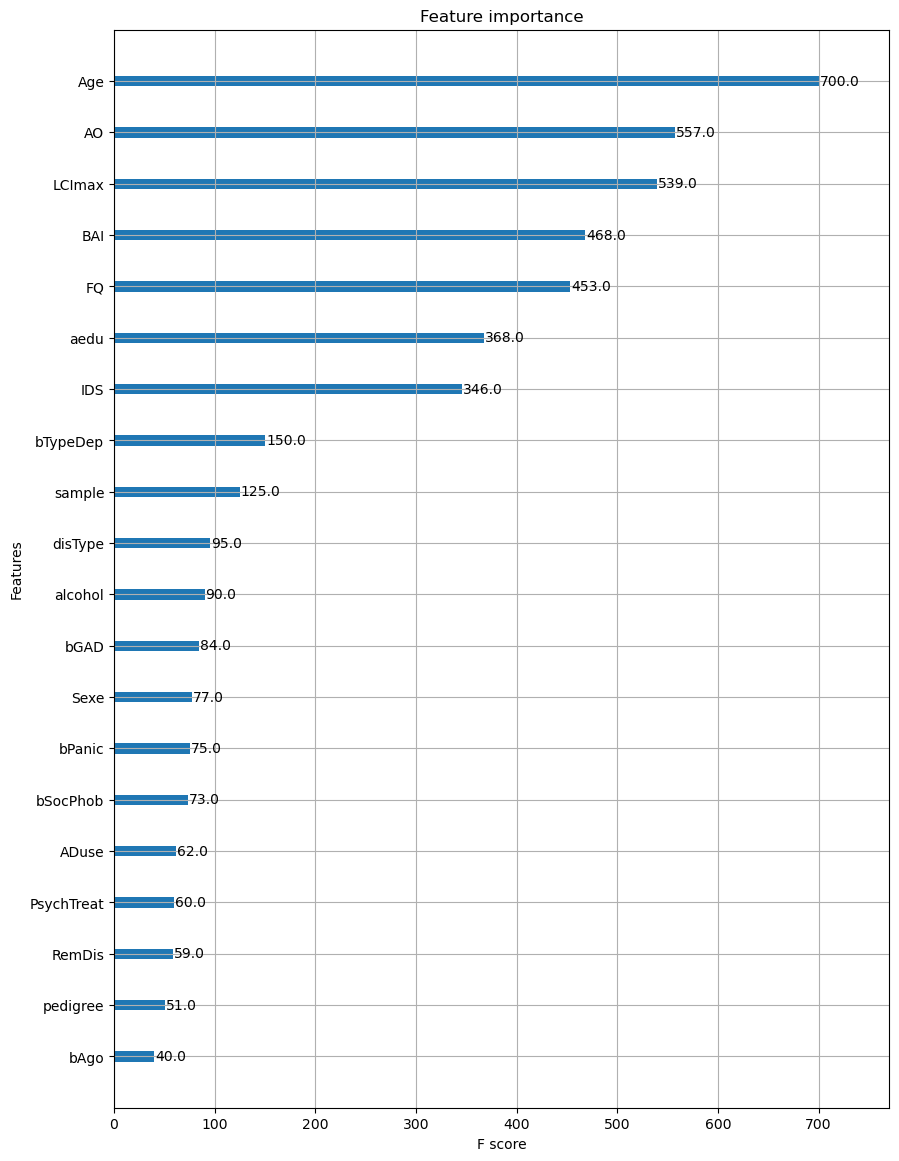

In [324]:
y_pred = boost.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the evaluation metrics
print("root mean squared error:", rmse)
print("mean absolute error:", mae)
print("R^2 score:", r2)
fig, ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(booster=xg_boost, ax=ax,)

In [325]:
# devide rmse by range of dep_sev_fu
print("root mean squared error divided by range of dep_sev_fu:", rmse/(max(y_test)-min(y_test)))

root mean squared error divided by range of dep_sev_fu: 0.17397427402233726


In [326]:
### MLP with Keras (ANN)
# keras tuner is used to find the best hyperparameters for the model
# build the model
hp = keras_tuner.HyperParameters()
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=20))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", default=2, min_value=1, max_value=4)):
        if i==0:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i+1}",default=128, min_value=30, max_value=515, step=25),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))
        if i==1:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i+1}",default=256, min_value=30, max_value=515, step=50),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))
        if i==2:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i+1}",default=256, min_value=30, max_value=515, step=50),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))

        
        else:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i+1}",default=100, min_value=30, max_value=515, step=50),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))
        
        if hp.Boolean(f"dropout_{i+1}", default=True):
            model.add(layers.Dropout(rate=hp.Choice(f'rate_{i+1}', default=0.25, values = [0.25,0.5,0.75])))



    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()],
    )
    return model

build_model(keras_tuner.HyperParameters())


In [327]:
# define the tuner
Tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=30,
    num_initial_points=2,
    seed=3337731,
    directory="ANN",
    project_name="MLP",
    #overwrite=True,
)

In [328]:
# convert train and test set to numpy arrays
X_train_np = X_train.to_numpy().astype('float32')
y_train_np = np.array(y_train).astype('float32')
X_test_np = np.array(X_test).astype('float32')
y_test_np = np.array(y_test).astype('float32')

#create validation set from the training set (20%)
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_np, y_train_np, test_size=0.2, random_state=3337731)

In [329]:
Tuner.search(X_train_np, y_train_np, epochs=200,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)],
            validation_data=(X_val_np, y_val_np),batch_size=20)

Trial 11 Complete [00h 00m 13s]
val_loss: 17.482295989990234

Best val_loss So Far: 17.131425857543945
Total elapsed time: 00h 04m 16s


In [ ]:
models_mlp = Tuner.get_best_models(num_models=3)
best_model_mlp = models_mlp[0]

best_model_mlp.summary()
best_model_mlp.evaluate(X_test_np, y_test_np)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 505)               32825     
                                                                 
 dense_2 (Dense)             (None, 505)               255530    
                                                                 
 dropout (Dropout)           (None, 505)               0         
                                                                 
 dense_3 (Dense)             (None, 30)                15180     
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0

[0.5687471628189087, 0.754153311252594, 0.6138402819633484]

In [ ]:
### Support Vector regression (this can be ignored)
# Create a nonlinear soft-margin SVR model
model = svm.SVC(kernel='rbf', gamma='auto')

# Define the hyperparameters to tune
hyperparameters = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Perform grid search using 5-fold cross validation
clf = GridSearchCV(model, hyperparameters, cv=10, verbose=0)

# Fit the model on the training and validation data
best_model = clf.fit(X_train, y_train)

# Print the best hyperparameters
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best Gamma:', best_model.best_estimator_.get_params()['gamma'])

# Print the accuracy score
print('Performance:', best_model.score(X_test, y_test))


c:\Users\felix.wente\anaconda3\envs\tf2_gpu\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Best C: 1000
Best Gamma: 0.0001
Performance: 0.06578947368421052


In [ ]:
ci = permutation_test_score(boost, gam, X_test, y_test, cv=10, n_permutations=1000, n_jobs=1, random_state=3337731, scoring='r2')

NameError: name 'model1' is not defined